<h1 style="text-align: center; font-weight: bold;">Initiation à l'Inverse Reinforcement Learning</h1>
<h3 style="text-align: center; color: gray;">Réimplémentation du Maximum Entropy IRL</h3>

In [2]:
from casadi import *
import numpy as np

## **Problème direct**

On cherche dans un premier temps à résoudre le problème d'optimisation suivant :

$$
\argmin\limits_{f \in \mathbb{R}^2} \omega^{\mathrm{T}} \Phi(f), \newline f_1, f_2 \geq 0
$$

avec $\omega^{\mathrm{T}} = \begin{bmatrix} \omega_1 & \omega_2 \end{bmatrix}$ et $\Phi(f)^{\mathrm{T}} = \begin{bmatrix} f_1^2 & (1 - f_2)^2 \end{bmatrix}$

In [ ]:
opti = Opti()

# Variables à optimiser
f1 = opti.variable()
f2 = opti.variable()

# Poids associés au coût total
# NOTE : il s'agit des constantes que l'on va chercher à retrouver par Inverse Reinforcement Learning
w1, w2 = 0.3, 0.7

# Définir la fonction objectif
opti.minimize(w1*f1**2 + w2*(f2 - 1)**2)
# NOTE : j'ai changé la fonction, de 2 à 3 variables pour pouvoir la visualiser dans R3, 
# et j'ai mis f2-1 au lieu de f2+1 pour que le minimum ne soit pas en (0,0,0) à cause des contraintes

# Ajouter les contraintes
opti.subject_to(f1 >= 0)
opti.subject_to(f2 >= 0)

# Choisir le solveur
opti.solver('ipopt')

# Résoudre le problème
sol = opti.solve()

# Récupérer les valeurs optimales
f1_opt = sol.value(f1)
f2_opt = sol.value(f2)

print("f1_opt =", f1_opt)
print("f2_opt =", f2_opt)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

On cherche maintenant à retrouver les poids de la fonction coût en utilisant des méthodes d'Inverse Reinforcement Learning. Pour ce faire, on va implémenter la méthode du Maximum Entropy Reinforcement Learning.

L'idée du Maximum Entropy Reinforcement Learning est d'attribuer une probabilité à chaque état. Un état de moindre coût a plus de chance (une probabilité plus grande) d'avoir lieu. On réimplémente proprement le problème.

On définit maintenant l'espace des trajectoires non optimales.

$-C(x,w) = w^{\mathrm{T}}*\Phi(x) = w_1x_1^2 + w_2(x_2 - 1)^2$

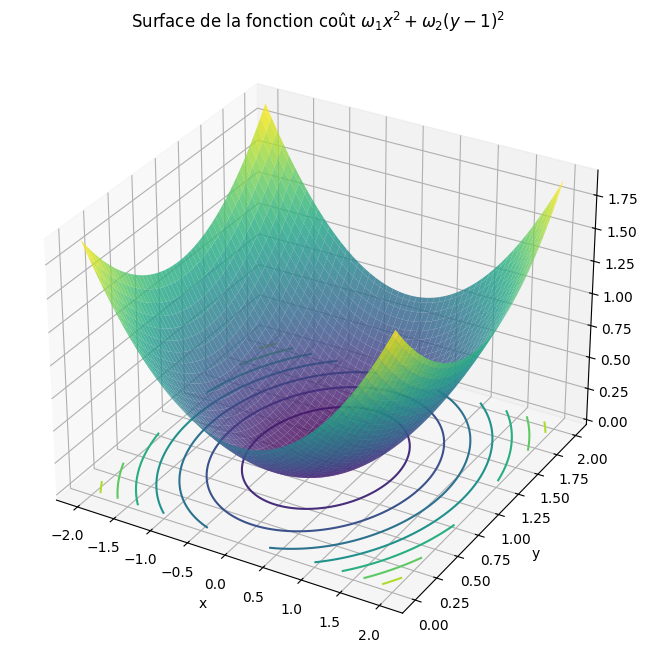

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Coefficients (déjà définis plus haut)
# w1 = 0.3
# w2 = 0.7

# Grille de points
x = np.linspace(-2, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)

# Fonction coût
Z = w1 * X**2 + w2 * (Y - 1)**2

# Tracé de la surface
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)

# Contours au sol
ax.contour(X, Y, Z, zdir='z', offset=0, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('y')
# ax.set_zlabel('z = 0.3 x^2 + 0.7 (y-1)^2')
ax.set_title(r'Surface de la fonction coût $\omega_1x^2 + \omega_2(y - 1)^2$')

plt.show()

In [ ]:
# paramètres de la simulation
np.random.seed(42)        
w_true = np.array([0.3, 0.7])
n_candidates = 500        # nombre d'échantillon pour l'ensemble "véritable" [0,2]x[0,2]
n_expert = 80             # nombre d'exemples experts D tirés selon la vraie distribution
domain_low, domain_high = 0.0, 2.0

# construction de [0,2]x[0,2]
S = np.random.uniform(domain_low, domain_high, size=(n_candidates, 2))

# fonction coût
def cost_numpy(F, w):
    c1 = F[:, 0]**2
    c2 = (F[:, 1] - 1.0)**2
    return w[0]*c1 + w[1]*c2

# distribution sur les échantillons de l'espace [0,2]x[0,2]
candidates_costs_true = cost_numpy(S, w_true)
#unnorm = np.exp(-candidates_costs_true - np.max(-candidates_costs_true))  # soustraction pour stabilité
unnorm = np.exp(-candidates_costs_true)
proba = unnorm / unnorm.sum()

# tirer des échantillons experts (indices) selon p(s)
expert_indices = np.random.choice(n_candidates, size=n_expert, replace=True, p=proba)
D = S[expert_indices, :] 

# formulation CasADi pour retrouver w
opti_inv = Opti()
w1_inv = opti_inv.variable()
w2_inv = opti_inv.variable()

# contraintes
# opti.subject_to(w1 >= 0)
# opti.subject_to(w2 >= 0)
opti_inv.subject_to(w1_inv + w2_inv == 1)

# convertir ensembles en DM (pour vectorisation CasADi)
S_DM = DM(S)   # shape (N,2)
D_DM = DM(D)   # shape (M,2)

# calcul vectorisé des coûts pour tous les candidats S (symbolique en w1,w2)
# c_S = w1 * (S[:,0]^2) + w2 * (S[:,1]-1)^2
c1_S = S_DM[:, 0]**2
c2_S = (S_DM[:, 1] - 1)**2
c_S = w1_inv * c1_S + w2_inv * c2_S          # vecteur (N,1) de coûts symboliques

# coûts des échantillons experts D
c1_D = D_DM[:, 0]**2
c2_D = (D_DM[:, 1] - 1)**2
c_D = w1_inv * c1_D + w2_inv * c2_D          # vecteur (M,1)

# log-vraisemblance négative (à minimiser) après réécriture
Z = sum1(exp(-c_S))                     # partition function    
obj = sum1(c_D) + DM(n_expert) * log(Z)

opti_inv.minimize(obj)

# initialisation pour ipopt
opti_inv.set_initial(w1_inv, 0.5)
opti_inv.set_initial(w2_inv, 0.5)

# résolution
opti_inv.solver('ipopt')
sol_inv = opti_inv.solve()

w1_inv_opt = sol_inv.value(w1_inv)
w2_inv_opt = sol_inv.value(w2_inv)

print("w_true =", w_true)
print("w_est  =", np.array([float(w1_inv_opt), float(w2_inv_opt)]))

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.9371096e+02 0.00e+00 7.19e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [12]:
new_opti = Opti()

# Variables à optimiser
f1_new = new_opti.variable()
f2_new = new_opti.variable()

# Poids associés au coût total
# NOTE : il s'agit des constantes que l'on va chercher à retrouver par Inverse Reinforcement Learning
# w1, w2 = 0.3, 0.7

# Définir la fonction objectif
new_opti.minimize(w1_inv_opt*f1_new**2 + w2_inv_opt*(f2_new - 1)**2)
# NOTE : j'ai changé la fonction, de 2 à 3 variables pour pouvoir la visualiser dans R3, 
# et j'ai mis f2-1 au lieu de f2+1 pour que le minimum ne soit pas en (0,0,0) à cause des contraintes

# Ajouter les contraintes
new_opti.subject_to(f1_new >= 0)
new_opti.subject_to(f2_new >= 0)

# Choisir le solveur
new_opti.solver('ipopt')

# Résoudre le problème
sol = new_opti.solve()

# Récupérer les valeurs optimales
f1_opt_new = sol.value(f1_new)
f2_opt_new = sol.value(f2_new)

print("f1_opt =", f1_opt_new)
print("f2_opt =", f2_opt_new)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.8108234e-01 0.00e+00 1.18e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [ ]:
# paramètres de la simulation
np.random.seed(42)        
w_true = np.array([0.3, 0.7])
n_candidates = 500        # nombre d'échantillon pour l'ensemble "véritable" [0,2]x[0,2]
n_expert = 80             # nombre d'exemples experts D tirés selon la vraie distribution
domain_low, domain_high = 0.0, 2.0

# construction de [0,2]x[0,2]
S = np.random.uniform(domain_low, domain_high, size=(n_candidates, 2))
# S = np.vstack([S, np.array([[f1_opt_new, f2_opt_new]])])  # ajouter f_star
# n_candidates += 1  # mettre à jour le nombre de candidats

# fonction coût
def cost_numpy(F, w):
    c1 = F[:, 0]**2
    c2 = (F[:, 1] - 1.0)**2
    return w[0]*c1 + w[1]*c2

# distribution sur les échantillons de l'espace [0,2]x[0,2]
candidates_costs_true = cost_numpy(S, w_true)
#unnorm = np.exp(-candidates_costs_true - np.max(-candidates_costs_true))  # soustraction pour stabilité
unnorm = np.exp(-candidates_costs_true)
proba = unnorm / unnorm.sum()

# tirer des échantillons experts (indices) selon p(s)
expert_indices = np.random.choice(n_candidates, size=n_expert, replace=True, p=proba)
D = S[expert_indices, :] 
D = np.vstack([D, np.array([[f1_opt_new, f2_opt_new]])])  # ajouter f_star

# formulation CasADi pour retrouver w
opti_inv_2 = Opti()
w1_inv = opti_inv_2.variable()
w2_inv = opti_inv_2.variable()

# contraintes
# opti.subject_to(w1 >= 0)
# opti.subject_to(w2 >= 0)
opti_inv_2.subject_to(w1_inv + w2_inv == 1)

# convertir ensembles en DM (pour vectorisation CasADi)
S_DM = DM(S)   # shape (N,2)
D_DM = DM(D)   # shape (M,2)

# calcul vectorisé des coûts pour tous les candidats S (symbolique en w1,w2)
# c_S = w1 * (S[:,0]^2) + w2 * (S[:,1]-1)^2
c1_S = S_DM[:, 0]**2
c2_S = (S_DM[:, 1] - 1)**2
c_S = w1_inv * c1_S + w2_inv * c2_S    

# coûts des échantillons experts D
c1_D = D_DM[:, 0]**2
c2_D = (D_DM[:, 1] - 1)**2
c_D = w1_inv * c1_D + w2_inv * c2_D    

# log-vraisemblance négative (à minimiser) après réécriture
Z = sum1(exp(-c_S))                     # partition function    
obj = sum1(c_D) + DM(n_expert) * log(Z)

opti_inv_2.minimize(obj)

# initialisation pour ipopt
opti_inv_2.set_initial(w1_inv, 0.5)
opti_inv_2.set_initial(w2_inv, 0.5)

# résolution
opti_inv_2.solver('ipopt')
sol_inv = opti_inv_2.solve()

w1_inv_opt = sol_inv.value(w1_inv)
w2_inv_opt = sol_inv.value(w2_inv)

print("w_true =", w_true)
print("w_est  =", np.array([float(w1_inv_opt), float(w2_inv_opt)]))


This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.9371096e+02 0.00e+00 7.19e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

## Tests à part

In [64]:
# Test en ajoutant la trajectoire optimale f_star dans le dataset S

# --------------------------
# paramètres de la simulation
# --------------------------
np.random.seed(42)        # reproductibilité
w_true = np.array([0.3, 0.7])
n_candidates = 500        # taille de l'ensemble S (discret)
n_expert = 80             # nombre d'exemples experts D tirés selon la vraie distribution
domain_low, domain_high = 0.0, 2.0

# --------------------------
# construire l'ensemble S de candidats (fixe)
# --------------------------
S = np.random.uniform(domain_low, domain_high, size=(n_candidates, 2))  # shape (N,2)
S = np.vstack([S, np.array([[0.0, 1.0]])])  # ajouter f_star
n_candidates += 1

# fonction coût (évaluée numériquement avec w_true) pour la simulation des experts
def cost_numpy(F, w):
    # F shape (N,2), w length 2
    c1 = F[:, 0]**2
    c2 = (F[:, 1] - 1.0)**2
    return w[0]*c1 + w[1]*c2

# distribution vraie p(s) ∝ exp(-C(s, w_true))
candidates_costs_true = cost_numpy(S, w_true)
#unnorm = np.exp(-candidates_costs_true - np.max(-candidates_costs_true))  # soustraction pour stabilité
unnorm = np.exp(-candidates_costs_true)
proba = unnorm / unnorm.sum()

# tirer des échantillons experts (indices) selon p(s)
expert_indices = np.random.choice(n_candidates, size=n_expert, replace=True, p=proba)
D = S[expert_indices, :]   # dataset expert (n_expert x 2)

# --------------------------
# Formulation CasADi pour retrouver w
# --------------------------
opti = Opti()
w1 = opti.variable()
w2 = opti.variable()

# contraintes simplex
# opti.subject_to(w1 >= 0)
# opti.subject_to(w2 >= 0)
opti.subject_to(w1 + w2 == 1)

# convertir ensembles en DM (pour vectorisation CasADi)
S_DM = DM(S)   # shape (N,2)
D_DM = DM(D)   # shape (M,2)

# calcul vectorisé des coûts pour tous les candidats S (symbolique en w1,w2)
# c_S = w1 * (S[:,0]^2) + w2 * (S[:,1]-1)^2
c1_S = S_DM[:, 0]**2
c2_S = (S_DM[:, 1] - 1)**2
c_S = w1 * c1_S + w2 * c2_S          # vecteur (N,1) de coûts symboliques

# coûts des échantillons experts D
c1_D = D_DM[:, 0]**2
c2_D = (D_DM[:, 1] - 1)**2
c_D = w1 * c1_D + w2 * c2_D          # vecteur (M,1)

# log-likelihood négative: sum_{d in D} c_d + M * log(sum_s exp(-c_s))
Z = sum1(exp(-c_S))                  # sum over candidates -> scalar (CasADi)
obj = sum1(c_D) + DM(n_expert) * log(Z)

opti.minimize(obj)

# initial guess (utile pour IPOPT)
opti.set_initial(w1, 0.5)
opti.set_initial(w2, 0.5)

# solve
opti.solver('ipopt')
sol = opti.solve()

w1_opt = sol.value(w1)
w2_opt = sol.value(w2)

print("w_true =", w_true)
print("w_est  =", np.array([float(w1_opt), float(w2_opt)]))


This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0108433e+02 0.00e+00 1.50e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [46]:
# Test avec uniquement la trajectoire optimale

best_indice = np.argmax(proba)
print("best indice:", best_indice)
print("best sample:", S[best_indice])
print("best sample cost:", candidates_costs_true[best_indice])
print("best sample proba:", proba[best_indice])


D_best = S[best_indice, :]   # dataset expert (n_expert x 2)

# --------------------------
# Formulation CasADi pour retrouver w
# --------------------------
opti_2 = Opti()
w1 = opti_2.variable()
w2 = opti_2.variable()

# contraintes simplex
# opti.subject_to(w1 >= 0)
# opti.subject_to(w2 >= 0)
opti_2.subject_to(w1 + w2 == 1)

# convertir ensembles en DM (pour vectorisation CasADi)
S_DM = DM(S)   # shape (N,2)
D_DM_best = DM(D_best)   # shape (M,2)

# calcul vectorisé des coûts pour tous les candidats S (symbolique en w1,w2)
# c_S = w1 * (S[:,0]^2) + w2 * (S[:,1]-1)^2
c1_S = S_DM[:, 0]**2
c2_S = (S_DM[:, 1] - 1)**2
c_S = w1 * c1_S + w2 * c2_S          # vecteur (N,1) de coûts symboliques

# coûts des échantillons experts D
c1_D = D_DM_best[0]**2
c2_D = (D_DM_best[1] - 1)**2
c_D = w1 * c1_D + w2 * c2_D          # vecteur (M,1)

# log-likelihood négative: sum_{d in D} c_d + M * log(sum_s exp(-c_s))
Z = sum1(exp(-c_S))                  # sum over candidates -> scalar (CasADi)
obj = sum1(c_D) + DM(1) * log(Z)

opti_2.minimize(obj)

# initial guess (utile pour IPOPT)
opti_2.set_initial(w1, 0.5)
opti_2.set_initial(w2, 0.5)

# solve
opti_2.solver('ipopt')
sol = opti_2.solve()

w1_opt = sol.value(w1)
w2_opt = sol.value(w2)

print("w_true =", w_true)
print("w_est  =", np.array([float(w1_opt), float(w2_opt)]))

best indice: 64
best sample: [0.01390426 1.02149461]
best sample cost: 0.00038141117824975953
best sample proba: 0.0033740194510811197
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    in